In [81]:
import pandas as pd
import boto3
import wordcloud
from io import BytesIO
import gzip
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

AWS_REGION = 'us-east-1'
MIN_SENTENCE_LENGTH_IN_CHARS = 10
MAX_SENTENCE_LENGTH_IN_CHARS = 4500
COMPREHEND_BATCH_SIZE = 25  ## This batch size results in groups no larger than 25 items
NUMBER_OF_BATCHES = 30
ROW_LIMIT = 10000

s3 = boto3.client('s3')
comprehend_client = boto3.client('comprehend', region_name = AWS_REGION)

In [82]:
bucket = "kranio-datalake"
key = "internal/webinar/leoCamilo/raw/complaints.csv"
key2 = "hub/complaints-training/complaints_training.csv"

obj = s3.get_object(Bucket=bucket, Key=key)
obj = BytesIO(obj['Body'].read())

obj2 = s3.get_object(Bucket=bucket, Key=key2)
obj2 = BytesIO(obj2['Body'].read())

df = pd.read_csv(obj)
df_groups = pd.read_csv(obj2, header=None)

# Data Cleaning

### Select columns

In [83]:
df = df[['Ticket #','Customer Complaint','Description']]

In [84]:
df.head()

,Ticket #,Customer Complaint,Description
0,250635,Comcast Cable Internet Speeds,I have been contacting Comcast Internet Techni...
1,223441,Payment disappear - service got disconnected,Back in January 2015 I made 2 payments: One fo...
2,242732,Speed and Service,Our home is located at in Acworth Georgia 3010...
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,Comcast in the Atlanta area has just put into ...
4,307175,Comcast not working and no service to boot,I have been a customer of Comcast of some sort...


### Remove punctuation/lower casing

In [85]:
# Load the regular expression library
import re
# Remove punctuation
df['text_processed'] = df['Customer Complaint'].map(lambda x: re.sub('[,\.!?-]', '', x,))
# Convert the titles to lowercase
df['text_processed'] = df['text_processed'].map(lambda x: x.lower())

In [86]:
# Print out the first rows of papers
df.head()

,Ticket #,Customer Complaint,Description,text_processed
0,250635,Comcast Cable Internet Speeds,I have been contacting Comcast Internet Techni...,comcast cable internet speeds
1,223441,Payment disappear - service got disconnected,Back in January 2015 I made 2 payments: One fo...,payment disappear service got disconnected
2,242732,Speed and Service,Our home is located at in Acworth Georgia 3010...,speed and service
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,Comcast in the Atlanta area has just put into ...,comcast imposed a new usage cap of 300gb that ...
4,307175,Comcast not working and no service to boot,I have been a customer of Comcast of some sort...,comcast not working and no service to boot


# Exploratory Analysis

### The most 50 words

(-0.5, 399.5, 299.5, -0.5)

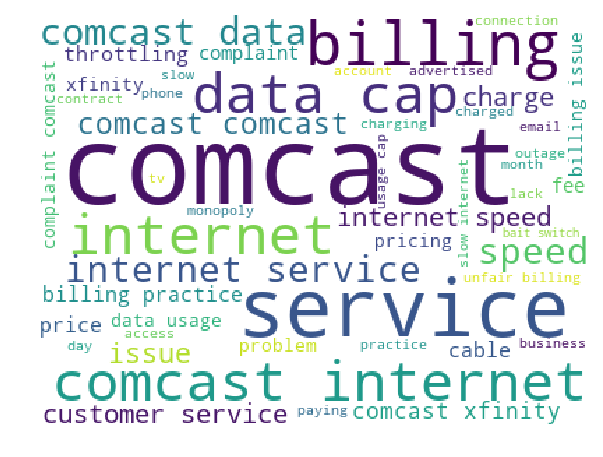

In [118]:
#pd.Series(' '.join(df['text_processed']).lower().split()).value_counts()[:50]

## documentation: https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as ESW

subjects = ' '.join(df['text_processed'])
fig, ax = plt.subplots(figsize=(10, 8))
wc = wordcloud.WordCloud(width=400, height=300, max_words=50, stopwords=ESW, background_color='white').generate(subjects)
ax.imshow(wc)
ax.axis("off")

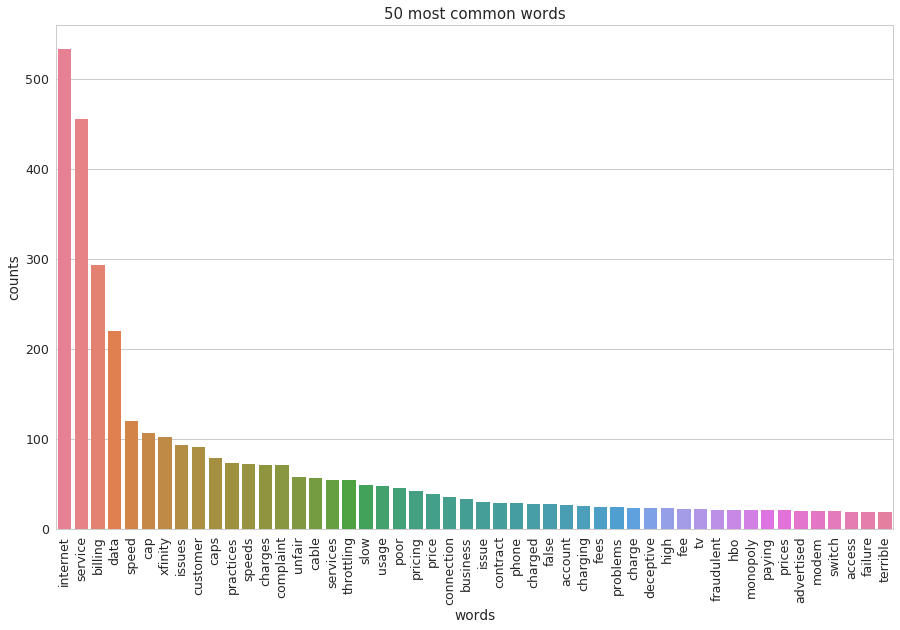

In [119]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def get_most_common_words(count_data, count_vectorizer, words_limit=10):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:words_limit]
    words = [w[0] for w in count_dict]
    
    return count_dict, words

    
def plot_10_most_common_words(count_data, count_vectorizer, words_limit):
    count_dict, words = get_most_common_words(count_data, count_vectorizer, words_limit)
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='50 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as ESW
stop_words = ['comcast']
stop_words = stop_words + list(ESW)

count_vectorizer = CountVectorizer(stop_words=stop_words)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['text_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer, 50)

In [89]:
count_dict, words = get_most_common_words(count_data, count_vectorizer, 50)

In [90]:
words

['internet',
 'service',
 'billing',
 'data',
 'speed',
 'cap',
 'xfinity',
 'issues',
 'customer',
 'caps',
 'practices',
 'speeds',
 'charges',
 'complaint',
 'unfair',
 'cable',
 'services',
 'throttling',
 'slow',
 'usage',
 'poor',
 'pricing',
 'price',
 'connection',
 'business',
 'issue',
 'contract',
 'phone',
 'charged',
 'false',
 'account',
 'charging',
 'fees',
 'problems',
 'charge',
 'deceptive',
 'high',
 'fee',
 'tv',
 'fraudulent',
 'hbo',
 'monopoly',
 'paying',
 'prices',
 'advertised',
 'modem',
 'switch',
 'access',
 'failure',
 'terrible']

In [107]:
def get_group_class(example_text):
    response = comprehend_client.classify_document(
        Text=example_text,
        EndpointArn="arn:aws:comprehend:us-east-1:193024568733:document-classifier-endpoint/compliants-training-v2"
    )
    
    classes = response["Classes"]
    
    group_class = None
    max_value = 0.0
    
    for c in classes:
        if c["Score"] > max_value:
            max_value = c["Score"]
            group_class = c["Name"]
        

    return group_class

In [113]:
df["group_class"] = df["text_processed"].iloc[:100].apply(get_group_class)

In [112]:
df.head(100)

,Ticket #,Customer Complaint,Description,text_processed,group_class
0,250635,Comcast Cable Internet Speeds,I have been contacting Comcast Internet Techni...,comcast cable internet speeds,Servicios
1,223441,Payment disappear - service got disconnected,Back in January 2015 I made 2 payments: One fo...,payment disappear service got disconnected,Servicios
2,242732,Speed and Service,Our home is located at in Acworth Georgia 3010...,speed and service,Servicios
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,Comcast in the Atlanta area has just put into ...,comcast imposed a new usage cap of 300gb that ...,Reclamos
4,307175,Comcast not working and no service to boot,I have been a customer of Comcast of some sort...,comcast not working and no service to boot,Reclamos
5,338519,ISP Charging for arbitrary data limits with ov...,To whom it may concern:\n I am a Comcast custo...,isp charging for arbitrary data limits with ov...,Comentarios
6,361148,Throttling service and unreasonable data caps,"Good morning,\n Comcast has been throttling my...",throttling service and unreasonable data caps,Reclamos
7,359792,Comcast refuses to help troubleshoot and corre...,When I moved to Michigan I contacted Comcast r...,comcast refuses to help troubleshoot and corre...,Reclamos
8,318072,Comcast extended outages,Comcast Xfinity cable service was interrupted ...,comcast extended outages,Servicios
9,371214,Comcast Raising Prices and Not Being Available...,"All of a sudden our ""bundle discount"" dropped ...",comcast raising prices and not being available...,Reclamos


# Generate Training Dataset

In [91]:
training_df = df.iloc[:1000]

In [92]:
training_df = training_df[["text_processed"]]

In [75]:
def find_group(example):
    group_selected = None
    for v in df_groups.values.tolist():
        group_id = v[0]
        keywords = v[1].split()

        for k in keywords:
            if k in example:
                group_selected = group_id
                break

    return group_selected if group_selected else "Comentarios"

training_df["group_id"] = training_df["text_processed"].apply(find_group)
training_df = training_df[["group_id", "text_processed"]]

In [80]:
result = training_df.to_csv(header=None, index=None)
result = bytes(result, 'utf-8')

key3 = "hub/complaints-training-complete/data.csv"
s3.put_object(Body=result, Bucket=bucket, Key=key3)

{'ResponseMetadata': {'RequestId': 'F6A94B5B1F509ACE',
  'HostId': '/+YOPhRavWPcC2BWiUfkt0G2/73Mg+p0CfF1BVYlpjZwTowuq0ZJldwSN9RaeycWJimKe9CiS+s=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '/+YOPhRavWPcC2BWiUfkt0G2/73Mg+p0CfF1BVYlpjZwTowuq0ZJldwSN9RaeycWJimKe9CiS+s=',
   'x-amz-request-id': 'F6A94B5B1F509ACE',
   'date': 'Mon, 20 Apr 2020 18:57:15 GMT',
   'x-amz-version-id': 'aBYFr1lLhi9LGiySFzTBcQmsBqouYdEK',
   'x-amz-server-side-encryption': 'aws:kms',
   'x-amz-server-side-encryption-aws-kms-key-id': 'arn:aws:kms:us-east-1:193024568733:key/e9e30521-b70d-46a5-9e7e-b923dbd5f43b',
   'etag': '"a2cdc86c1ad36583e9f29c958e7d4c8b"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"a2cdc86c1ad36583e9f29c958e7d4c8b"',
 'ServerSideEncryption': 'aws:kms',
 'VersionId': 'aBYFr1lLhi9LGiySFzTBcQmsBqouYdEK',
 'SSEKMSKeyId': 'arn:aws:kms:us-east-1:193024568733:key/e9e30521-b70d-46a5-9e7e-b923dbd5f43b'}